In [6]:
import numpy as np
from matplotlib import pyplot as plt
import cv2
import bitstring
import struct

In [7]:
img_path = 'coverimg.jpg'
img_array = cv2.imread(img_path, flags=cv2.IMREAD_COLOR)
# img_rgb = cv2.cvtColor(img_array, cv2.COLOR_BGR2RGB)
# plt.imshow(img_rgb)

data = "supersecretinfo.txt"
hidden_data = open(data, "rb")
message = hidden_data.read().decode('utf-8')


In [ ]:
JPG_luminance_table = np.array([
# <---general brightness variations---
  [16, 11, 10, 16,  24, 40,   51,  61], # |
  [12, 12, 14, 19,  26, 58,   60,  55], # |
  [14, 13, 16, 24,  40, 57,   69,  56], # |
  [14, 17, 22, 29,  51, 87,   80,  62], # | fine details and sharp edges
  [18, 22, 37, 56,  68, 109, 103,  77], # |
  [24, 36, 55, 64,  81, 104, 113,  92], # | 
  [49, 64, 78, 87, 103, 121, 120, 101], # |
  [72, 92, 95, 98, 112, 100, 103,  99]  # \/
])

def slice_image_8x8(image):
  blocks = []
  for vertic_slice in np.vsplit(image, int(image.shape[0] / 8)):
    for horiz_slice in np.hsplit(vertic_slice, int(image.shape[1] / 8)):
      blocks.append(horiz_slice)
  return blocks

def zigzag(a: np.ndarray) -> np.ndarray:
  a = np.asarray(a)
  rows, cols = a.shape
  out = []

  # s = i + j is the diagonal index
  for s in range(rows + cols - 1):
    if s % 2 == 0:
      # even diagonal: go "up-right"
      r = min(s, rows - 1)
      c = s - r
      while r >= 0 and c < cols:
          out.append(a[r, c])
          r -= 1
          c += 1
    else:
        # odd diagonal: go "down-left"
        c = min(s, cols - 1)
        r = s - c
        while c >= 0 and r < rows:
          out.append(a[r, c])
          r += 1
          c -= 1

  return np.array(out)

def inverse_zigzag(seq, rows: int, cols: int) -> np.ndarray:
  seq = np.asarray(seq)
  a = np.zeros((rows, cols), dtype=seq.dtype)
  idx = 0

  for s in range(rows + cols - 1):
    if s % 2 == 0:
      # even diagonal: fill "up-right"
      r = min(s, rows - 1)
      c = s - r
      while r >= 0 and c < cols:
        a[r, c] = seq[idx]
        idx += 1
        r -= 1
        c += 1
    else:
      # odd diagonal: fill "down-left"
      c = min(s, cols - 1)
      r = s - c
      while c >= 0 and r < rows:
        a[r, c] = seq[idx]
        idx += 1
        r += 1
        c -= 1

  return a

def encode_stego(encoded_bits, dct_blocks):
  encoded_bits.pos = 0
  header = bitstring.pack('uint:32', len(encoded_bits))
  payload = header + encoded_bits
  payload.pos = 0
  total_bits = len(payload)

  converted_blocks = []
  data_complete = False

  for block_idx, block in enumerate(dct_blocks):
    block = np.array(block, dtype=np.float32)

    for i in range(1, len(block)):
      if payload.pos >= total_bits:
        data_complete = True
        break

      coeff = int(block[i])
      if coeff > 1:
        packed = bitstring.pack('uint:8', np.uint8(coeff))
        packed[-1] = payload.read(1)
        block[i] = float(packed.read('uint:8'))

    converted_blocks.append(block)

    if data_complete:
      for rest_block in dct_blocks[block_idx + 1:]:
        converted_blocks.append(np.array(rest_block, dtype=np.float32))
      break

  if not data_complete:
    raise ValueError("Data didn't fully embed")

  return converted_blocks

def construct_stego(block_width, block_segments):
  image_rows = []
  temp = []
  for i in range(len(block_segments)):
      if i > 0 and not(i % int(block_width / 8)):
        image_rows.append(temp)
        temp = [block_segments[i]]
      else:
        temp.append(block_segments[i])
  image_rows.append(temp)

  return np.block(image_rows)

def extract_stego(dct_blocks):
  bits = bitstring.BitStream()
  for current_dct_block in dct_blocks:
    for i in range(1, len(current_dct_block)):
      coeff = int(current_dct_block[i])
      if coeff > 1:
        lsb = np.uint8(coeff) & 0x01
        bits.append(f'uint:1={lsb}')
  return bits

def cal_peaksnr(img1, img2):
  SNR = np.mean((img1 - img2) ** 2)
  if SNR == 0:
    return float('inf')
  max_pixel = 255.0
  peak_snr = 10 * np.log10(max_pixel / np.sqrt(SNR))
  return peak_snr

In [ ]:
img_path = 'coverimg.jpg'
img_array = cv2.imread(img_path, flags=cv2.IMREAD_COLOR)  # BGR

data = "supersecretinfo.txt"
with open(data, "rb") as f:
  message = f.read().decode('utf-8')

height, width = img_array.shape[:2]
padded_image = cv2.resize(img_array, (width, height))

float_padded = np.float32(padded_image)
blocks = slice_image_8x8(float_padded)
stego_image = np.empty_like(float_padded)

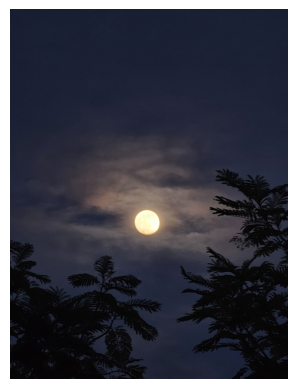

1901 characters saved


In [ ]:
for channel in range(3):
  channel_blocks = np.array([block[:, :, channel] for block in blocks])
  dct_blocks = np.array([cv2.dct(block.astype(np.float32)) for block in channel_blocks])
  dct_quantize = np.array([dct_block / JPG_luminance_table for dct_block in dct_blocks])
  dct_quantize_int = np.round(dct_quantize)

  sorted_coefficients = [zigzag(q) for q in dct_quantize_int]
  if channel == 0:
    ascii_bytes = message.encode('ascii')
    bits = bitstring.BitStream()
    for byte in ascii_bytes:
      bits.append(f'uint:8={byte}')
    embedded_dct_blocks = encode_stego(bits, sorted_coefficients)
    coeffs_to_use = embedded_dct_blocks
  else:
    coeffs_to_use = sorted_coefficients

  desorted_coefficients = [inverse_zigzag(block, 8, 8) for block in coeffs_to_use]
  dct_dequants = [data * JPG_luminance_table for data in desorted_coefficients]
  idct_blocks = [cv2.idct(block) for block in dct_dequants]

  stego_image[:, :, channel] = construct_stego(width, idct_blocks)
  
stego_bgr = np.uint8(np.clip(stego_image, 0, 255))

plt.imshow(cv2.cvtColor(stego_bgr, cv2.COLOR_BGR2RGB))
cv2.imwrite("./stegoimg.png", stego_bgr)
print(len(message), "characters saved")

In [11]:
stego_image = cv2.imread("./stegoimg.png", flags=cv2.IMREAD_COLOR)  # BGR
stego_image_float = np.float32(stego_image)
stego_blocks = slice_image_8x8(stego_image_float)
stego_chan = np.array([block[:, :, 0] for block in stego_blocks])

dct_blocks = [cv2.dct(block.astype(np.float32)) for block in stego_chan]
dct_quants = [block / JPG_luminance_table for block in dct_blocks]
dct_quants_int = [np.round(q) for q in dct_quants]

zigzag_blocks = [zigzag(q) for q in dct_quants_int]
recovered_data = extract_stego(zigzag_blocks)
total_bits = len(recovered_data)
print("Total bits read:", total_bits)

if total_bits < 32:
    print("Invalid Format")
else:
    recovered_data.pos = 0
    length_bits = recovered_data.read('uint:32')
    available_bits = total_bits - 32

    usable_bits = min(length_bits, available_bits)
    usable_bits -= usable_bits % 8
    data_len = usable_bits // 8

    buf = bytearray()
    for _ in range(data_len):
        buf.append(recovered_data.read('uint:8'))

    secret = bytes(buf).decode('ascii', errors='replace')
    print("Message read:")
    print(secret)

Total bits read: 28137
Message read:
The basic intuition behind gradient descent can be illustrated by a hypothetical scenario. People are stuck in the mountains and are trying to get down (i.e., trying to find the global minimum). There is heavy fog such that visibility is extremely low. Therefore, the path down the mountain is not visible, so they must use local information to find the minimum. They can use the method of gradient descent, which involves looking at the steepness of the hill at their current position, then proceeding in the direction with tHe steepest descent (i.e., downhill). If they were trying to find the top of the mountain (i.e., the iaximum), then!they would proceed in the direction of steepest ascent (i.e., uphill). Using this method, they would eventually find their way down the mountain or possibly get stuck in some hole (i.e., local minimum or saddle point), like a mountain lake. However, assume also that the steepness of the hill is not immediately obvious w

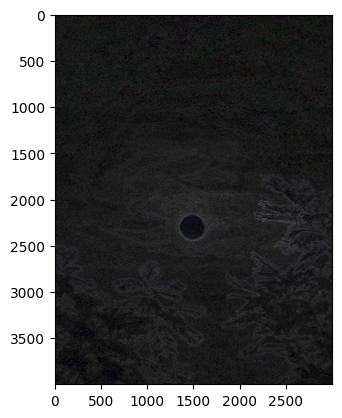

In [ ]:
orig  = cv2.imread("coverimg.jpg").astype(np.float32)
stego = cv2.imread("stegoimg.png").astype(np.float32)

diff = np.abs(stego - orig) 
vis  = np.clip(diff * 20, 0, 255)
vis  = vis.astype(np.uint8)

stego_dct_blocks = dct_blocks

img_path = 'coverimg.jpg'
img_array = cv2.imread(img_path, flags=cv2.IMREAD_COLOR)  # BGR

data = "supersecretinfo.txt"
with open(data, "rb") as f:
  message = f.read().decode('utf-8')

plt.imshow(cv2.cvtColor(vis, cv2.COLOR_BGR2RGB))